In [1]:
!pip install matplotlib scikit-image

import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage.io import imread
from skimage.color import rgb2gray
from skimage import exposure
from skimage import color
from skimage.feature import hog
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage.morphology import binary_erosion
from skimage.measure import regionprops, find_contours

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


2023-07-25 23:48:28.018717: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-25 23:48:28.043057: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'Dataset/' + x)
df.head()

,filepaths,suit
0,Dataset/train/ace of clubs/001.jpg,clubs
1,Dataset/train/ace of clubs/002.jpg,clubs
2,Dataset/train/ace of clubs/003.jpg,clubs
3,Dataset/train/ace of clubs/004.jpg,clubs
4,Dataset/train/ace of clubs/005.jpg,clubs


In [3]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

Train Set - Class Distribution:
spades      0.269171
hearts      0.246010
diamonds    0.243675
clubs       0.241144
Name: suit, dtype: float64
Validation Set - Class Distribution:
spades      0.269261
hearts      0.245914
diamonds    0.243580
clubs       0.241245
Name: suit, dtype: float64
Test Set - Class Distribution:
spades      0.268991
hearts      0.245953
diamonds    0.244085
clubs       0.240971
Name: suit, dtype: float64


## Augment Images

In [4]:
# Initialize data generator class

train_data_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range= 45,
    zoom_range= 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_data_generator = ImageDataGenerator(rescale = 1/255.0)

# Create data generators for train, validation, and test
batch_size = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_generator = train_data_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)


test_generator = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
)


Found 5138 validated image filenames belonging to 4 classes.
Found 1285 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


In [5]:
def preprocess_image(image):
    # Convert the image to grayscale.
    if len(image.shape) == 3 and image.shape[-1] == 3:
        image = color.rgb2gray(image)
    return image

In [6]:
def detect_suit_regions(image_path):
    image = load_img(image_path)
    image_array = img_to_array(image)

    # convert image to grayscale.
    image_array = preprocess_image(image_array)

    # Convert the image to binary using Otsu's thresholding.
    # Otsu's thresholding divides the pixels of the image into two classes: foreground and background.
    # Helps isolate region of interest for feature extraction
    binary_image = image_array > threshold_otsu(image_array)

    # Erode the binary image to enhance the suits.
    # Eroding reduces the size of the white regions of the foreground.
    eroded_image = binary_erosion(binary_image)

    # Find contours, the outlines that have the same intensity, in the eroded image.
    contours = find_contours(eroded_image, 0.8)

    # Check if any contours are detected.
    # If not, then return None
    if not contours:
        print(f"No suit regions detected for {image_path}")
        return None

    # Find the largest contour, assuming it corresponds to the suit region.
    suit_contour = max(contours, key=lambda x: x[:, 0].size)

    # Get the bounding box of the suit contour.
    minr, minc = np.min(suit_contour, axis=0).astype(int)
    maxr, maxc = np.max(suit_contour, axis=0).astype(int)

    # Check if the bounding box has valid dimensions (not too small).
    min_size = 10
    if maxr - minr < min_size or maxc - minc < min_size:
        print(f"Suit region too small for HOG features in {image_path}")
        return None

    # Crop the suit region from the original image.
    suit_image = image_array[minr:maxr, minc:maxc]

    # Calculate HOG features for the suit region.
    fd, hog_image = hog(suit_image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Normalize the HOG features.
    hog_features = exposure.rescale_intensity(fd, in_range=(0, 10))

    return hog_features



In [7]:
# Extract the HOG features from the DataFrame and create a list of feature arrays.
hog_features_list_train = []
y_train_collected = []

for i in range(len(train_generator.filenames)):
    image_path = train_generator.filepaths[i]
    hog_features = detect_suit_regions(image_path)
    if hog_features is not None:
        if len(hog_features) == 768: 
            hog_features_list_train.append(hog_features)
            y_train_collected.append(train_generator.labels[i])

# Convert the list of HOG feature arrays into a 2D array
hog_features_array_train = np.vstack(hog_features_list_train)
y_train_collected = np.array(y_train_collected)

Suit region too small for HOG features in Dataset/train/nine of diamonds/062.jpg
Suit region too small for HOG features in Dataset/train/four of spades/138.jpg
Suit region too small for HOG features in Dataset/train/seven of spades/058.jpg
Suit region too small for HOG features in Dataset/train/ace of hearts/098.jpg
Suit region too small for HOG features in Dataset/train/four of spades/047.jpg
Suit region too small for HOG features in Dataset/train/ten of spades/099.jpg
Suit region too small for HOG features in Dataset/train/three of spades/052.jpg
Suit region too small for HOG features in Dataset/train/three of spades/093.jpg
Suit region too small for HOG features in Dataset/train/two of hearts/084.jpg
Suit region too small for HOG features in Dataset/train/ten of spades/075.jpg
Suit region too small for HOG features in Dataset/train/three of clubs/054.jpg
Suit region too small for HOG features in Dataset/train/four of spades/139.jpg
Suit region too small for HOG features in Dataset/t

Suit region too small for HOG features in Dataset/train/nine of spades/125.jpg
Suit region too small for HOG features in Dataset/train/four of hearts/014.jpg
Suit region too small for HOG features in Dataset/train/six of spades/067.jpg
Suit region too small for HOG features in Dataset/train/three of diamonds/112.jpg
Suit region too small for HOG features in Dataset/train/ten of clubs/048.jpg
Suit region too small for HOG features in Dataset/train/four of diamonds/112.jpg
Suit region too small for HOG features in Dataset/train/six of diamonds/042.jpg
Suit region too small for HOG features in Dataset/train/five of spades/088.jpg
Suit region too small for HOG features in Dataset/train/three of hearts/046.jpg
Suit region too small for HOG features in Dataset/train/six of hearts/019.jpg
Suit region too small for HOG features in Dataset/train/two of spades/004.jpg
Suit region too small for HOG features in Dataset/train/two of diamonds/064.jpg
Suit region too small for HOG features in Dataset

In [8]:
# Extract HOG features for validation data
hog_features_list_valid = []
y_valid_collected = []

for i in range(len(valid_generator.filenames)):
    image_path = valid_generator.filepaths[i]
    hog_features = detect_suit_regions(image_path)
    if hog_features is not None and len(hog_features) == 768:
        hog_features_list_valid.append(hog_features)
        y_valid_collected.append(valid_generator.labels[i])

# Convert the list of HOG feature arrays into a 2D array
hog_features_array_valid = np.vstack(hog_features_list_valid)
y_valid_collected = np.array(y_valid_collected)

Suit region too small for HOG features in Dataset/train/ace of diamonds/045.jpg
Suit region too small for HOG features in Dataset/train/six of diamonds/126.jpg
Suit region too small for HOG features in Dataset/train/seven of hearts/107.jpg
Suit region too small for HOG features in Dataset/train/seven of clubs/054.jpg
Suit region too small for HOG features in Dataset/train/eight of diamonds/002.jpg
Suit region too small for HOG features in Dataset/train/three of diamonds/048.jpg
Suit region too small for HOG features in Dataset/train/seven of hearts/033.jpg
Suit region too small for HOG features in Dataset/train/six of clubs/102.jpg
Suit region too small for HOG features in Dataset/train/six of hearts/005.jpg
Suit region too small for HOG features in Dataset/train/nine of clubs/063.jpg
Suit region too small for HOG features in Dataset/train/three of diamonds/024.jpg
Suit region too small for HOG features in Dataset/train/ace of diamonds/058.jpg
Suit region too small for HOG features in 

In [9]:
# Extract HOG features for test data
hog_features_list_test = []
y_test_collected = []

for i in range(len(test_generator.filenames)):
    image_path = test_generator.filepaths[i]
    hog_features = detect_suit_regions(image_path)
    if hog_features is not None and len(hog_features) == 768:
        hog_features_list_test.append(hog_features)
        y_test_collected.append(test_generator.labels[i])

# Convert the list of HOG feature arrays into a 2D array
hog_features_array_test = np.vstack(hog_features_list_test)
y_test_collected = np.array(y_test_collected)

Suit region too small for HOG features in Dataset/train/six of diamonds/049.jpg
Suit region too small for HOG features in Dataset/train/three of hearts/049.jpg
Suit region too small for HOG features in Dataset/train/ten of clubs/054.jpg
Suit region too small for HOG features in Dataset/train/four of hearts/077.jpg
Suit region too small for HOG features in Dataset/train/eight of clubs/002.jpg
Suit region too small for HOG features in Dataset/train/ace of hearts/116.jpg
Suit region too small for HOG features in Dataset/train/eight of spades/072.jpg
Suit region too small for HOG features in Dataset/train/seven of hearts/101.jpg
Suit region too small for HOG features in Dataset/train/five of hearts/039.jpg
Suit region too small for HOG features in Dataset/train/ace of clubs/054.jpg
Suit region too small for HOG features in Dataset/train/seven of hearts/044.jpg
Suit region too small for HOG features in Dataset/train/six of spades/068.jpg
Suit region too small for HOG features in Dataset/tra

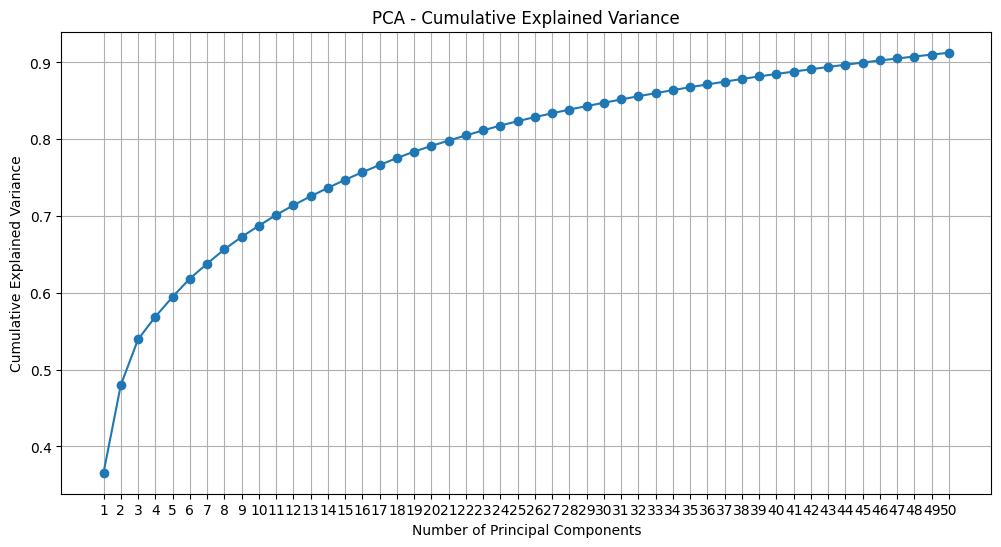

In [10]:
# Perform PCA on the HOG features.
pca = PCA()
hog_features_pca = pca.fit_transform(hog_features_array_train)

# Cumulative explained variance.
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Number of principal components to plot from 1 to 50.
components_range = np.arange(1, 51)

plt.figure(figsize=(12, 6))
plt.plot(components_range, cumulative_explained_variance[components_range - 1], marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.xticks(components_range)
plt.grid(True)
plt.show()

In [25]:
from sklearn.metrics import classification_report, accuracy_score

def least_squares_train_one_vs_all(X_train, y_train, class_label):
    # Convert the multi-class labels to binary labels (1 for the current class, 0 for all others).
    y_train_binary = (y_train == class_label).astype(int)
    
    # Add a column of ones to the feature matrix for the bias term.
    X_train_bias = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
    
    # Calculate the weight matrix using the least squares method for the current class.
    w = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train_binary
    
    return w

# Define the classes for multi-class classification
classes = [0, 1, 2, 3]

# Training the least squares classifier for each class
weights_list = []
for class_label in classes:
    weights_list.append(least_squares_train_one_vs_all(hog_features_array_train, y_train_collected, class_label))

# Making predictions on validation and test data for each class
y_pred_valid_labels = np.array([predict(hog_features_array_valid, weights, threshold=0.5) for weights in weights_list]).T
y_pred_test_labels = np.array([predict(hog_features_array_test, weights, threshold=0.5) for weights in weights_list]).T

# Determine the predicted class label for each sample
y_pred_valid_multi_class = np.argmax(y_pred_valid_labels, axis=1)
y_pred_test_multi_class = np.argmax(y_pred_test_labels, axis=1)

# Calculate accuracy on validation and test data for multi-class classification
accuracy_valid = accuracy_score(y_valid_collected, y_pred_valid_multi_class)
accuracy_test = accuracy_score(y_test_collected, y_pred_test_multi_class)

print(f"Accuracy on validation data: {accuracy_valid}")
print(f"Accuracy on test data: {accuracy_test}")

# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_names = list(test_generator.class_indices.keys())

# Calculate classification report (F1 score, recall, and precision) for multi-class classification
print("Classification Report for Validation Data:")
print(classification_report(y_valid_collected, y_pred_valid_multi_class, target_names=class_names))

print("Classification Report for Test Data:")
print(classification_report(y_test_collected, y_pred_test_multi_class, target_names=class_names))


Accuracy on validation data: 0.6129032258064516
Accuracy on test data: 0.5555555555555556
Classification Report for Validation Data:
              precision    recall  f1-score   support

       clubs       0.81      0.71      0.76        24
    diamonds       0.25      0.20      0.22         5
      hearts       0.20      1.00      0.33         1
      spades       0.00      0.00      0.00         1

    accuracy                           0.61        31
   macro avg       0.31      0.48      0.33        31
weighted avg       0.67      0.61      0.63        31

Classification Report for Test Data:
              precision    recall  f1-score   support

       clubs       0.58      0.84      0.69        25
    diamonds       0.50      0.33      0.40         6
      hearts       0.33      0.12      0.18         8
      spades       0.50      0.17      0.25         6

    accuracy                           0.56        45
   macro avg       0.48      0.37      0.38        45
weighted avg   

## Sample Images

In [ ]:
# Display some sample images
def detect_suit_regions(image_path):
    image = load_img(image_path)
    image_array = img_to_array(image)

    # convert image to grayscale.
    image_array = preprocess_image(image_array)

    # Convert the image to binary using Otsu's thresholding.
    # Otsu's thresholding divides the pixels of the image into two classes: foreground and background.
    # Helps isolate region of interest for feature extraction
    binary_image = image_array > threshold_otsu(image_array)

    # Erode the binary image to enhance the suits.
    # Eroding reduces the size of the white regions of the foreground.
    eroded_image = binary_erosion(binary_image)

    # Find contours, the outlines that have the same intensity, in the eroded image.
    contours = find_contours(eroded_image, 0.8)

    # Check if any contours are detected.
    # If not, then return None
    if not contours:
        print(f"No suit regions detected for {image_path}")
        return None

    # Find the largest contour, assuming it corresponds to the suit region.
    suit_contour = max(contours, key=lambda x: x[:, 0].size)

    # Get the bounding box of the suit contour.
    minr, minc = np.min(suit_contour, axis=0).astype(int)
    maxr, maxc = np.max(suit_contour, axis=0).astype(int)

    # Check if the bounding box has valid dimensions (not too small).
    min_size = 10
    if maxr - minr < min_size or maxc - minc < min_size:
        print(f"Suit region too small for HOG features in {image_path}")
        return None

    # Crop the suit region from the original image.
    suit_image = image_array[minr:maxr, minc:maxc]

    # Calculate HOG features for the suit region.
    fd, hog_image = hog(suit_image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Normalize the HOG features.
    hog_features = exposure.rescale_intensity(fd, in_range=(0, 10))

    # Plot the original image and the HOG features.
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    ax[1].imshow(suit_image, cmap='gray')
    ax[1].add_patch(patches.Rectangle((minc, minr), maxc - minc, maxr - minr, linewidth=1, edgecolor='r', facecolor='none'))
    ax[1].set_title('Suit Region')
    ax[1].axis('off')

    ax[2].imshow(hog_image, cmap='gray')
    ax[2].set_title('HOG Features')
    ax[2].axis('off')

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    plt.show()

    return hog_features

# Sample image paths
image_paths = [
    'Dataset/train/three of diamonds/006.jpg',
    'Dataset/train/three of diamonds/002.jpg',
    'Dataset/train/ace of diamonds/064.jpg',
    'Dataset/train/ace of diamonds/063.jpg',
    'Dataset/train/nine of clubs/024.jpg',
    'Dataset/train/nine of clubs/070.jpg',
    'Dataset/train/ace of clubs/066.jpg',
    'Dataset/train/ace of clubs/047.jpg',
    'Dataset/train/queen of hearts/005.jpg',
    'Dataset/train/three of hearts/056.jpg',
    'Dataset/train/two of hearts/033.jpg',
    'Dataset/train/king of spades/005.jpg',
    'Dataset/train/jack of spades/014.jpg',
    'Dataset/train/jack of spades/055.jpg'
]

for i in image_paths:
    detect_suit_regions(i)